# Variational Autoencoder with MNIST Data

Using code examples from Chapter 6 of First Edition: [deep-learning-with-python-notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks)

In [2]:
## Import the necessary modules for the assignment.
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
import keras
import sklearn
import itertools
import string
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from pathlib import Path
from contextlib import redirect_stdout
import time
import os
import random
import sys

## Import the necessary keras components.
from keras import layers, models, preprocessing
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, np_utils
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation, Flatten, Embedding
from keras.optimizers import RMSprop
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [3]:
## Print versions of essential packages
print("keras version: {}".format(keras.__version__))
print("tensorflow version: {}".format(tf.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))

keras version: 2.11.0
tensorflow version: 2.11.0
pandas version: 1.5.3
numpy version: 1.24.2


## Assignment 12 Criteria

Using section 8.4 in Deep Learning with Python as a guide, implement a variational autoencoder using the MNIST data set and save a grid of 15 x 15 digits to the results/vae directory. If you would rather work on a more interesting dataset, you can use the CelebFaces Attributes Dataset instead.

In [4]:
'''
Example Code from 8.4 in Deep Learning with Python provided below for reference:
***************************************************************
# Encode the input into a mean and variance parameter
z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
reconstructed_img = decoder(z)

# Instantiate a model
model = Model(input_img, reconstructed_img)

# Then train the model using 2 losses:
# a reconstruction loss and a regularization loss
***************************************************************
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
********************************************************************
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
*********************************************************************
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)
**********************************************************************
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])
************************************************************************
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

**************************************************************************
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
'''


"\nExample Code from 8.4 in Deep Learning with Python provided below for reference:\n***************************************************************\n# Encode the input into a mean and variance parameter\nz_mean, z_log_variance = encoder(input_img)\n\n# Draw a latent point using a small random epsilon\nz = z_mean + exp(z_log_variance) * epsilon\n\n# Then decode z back to an image\nreconstructed_img = decoder(z)\n\n# Instantiate a model\nmodel = Model(input_img, reconstructed_img)\n\n# Then train the model using 2 losses:\n# a reconstruction loss and a regularization loss\n***************************************************************\nimg_shape = (28, 28, 1)\nbatch_size = 16\nlatent_dim = 2  # Dimensionality of the latent space: a plane\n\ninput_img = keras.Input(shape=img_shape)\n\nx = layers.Conv2D(32, 3,\n                  padding='same', activation='relu')(input_img)\nx = layers.Conv2D(64, 3,\n                  padding='same', activation='relu',\n                  strides=(2, 2))(

### Create Directories

In [5]:
results_dir = Path('C:/Users/jkmey/Documents/Github/DSC650_Course_Assignments/dsc650/dsc650/assignments/assignment12/').joinpath('results').joinpath('vae')
results_dir.mkdir(parents = True, exist_ok = True)

### Create Encoder Network (Simple Convnet)

In [6]:
'''
Encoder network: A simple convnet which maps the input image x to two vectors, z_mean and z_log_variance.
'''
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

### Create Sampling Function

In [7]:
'''
Here is the code for using z_mean and z_log_var, the parameters of the statistical distribution assumed to 
have produced input_img, to generate a latent space point z. Here, we wrap some arbitrary code 
(built on top of Keras backend primitives) into a Lambda layer. In Keras, everything needs to be a layer, 
so code that isn't part of a built-in layer should be wrapped in a Lambda (or else, in a custom layer).
'''
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

### Decoder Implementation

In [8]:
'''
This is the decoder implementation: we reshape the vector z to the dimensions of an image, 
then we use a few convolution layers to obtain a final image output that has the same dimensions 
as the original input_img.
'''
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

### Create Custom Variational Layer Class

In [9]:
'''
The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form loss(input, target). 
Thus, we set up the loss by writing a custom layer with internally leverages the built-in add_loss layer method to create
an arbitrary loss.
'''
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

### Instantiate and Train the Model

In [10]:
'''
Finally, we instantiate and train the model. Since the loss has been taken care of in our custom layer, 
we don't specify an external loss at compile time (loss=None), 
which in turns means that we won't pass target data during training 
(as you can see we only pass x_train to the model in fit).
'''
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

C:\Users\jkmey\anaconda3\envs\dsc650\lib\site-packages\keras\engine\training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 113s 2ms/sample - loss: 0.2098 - val_loss: 0.1952
Epoch 2/10
60000/60000 [==============================] - 112s 2ms/sample - loss: 0.1921 - val_loss: 0.1893
Epoch 3/10
60000/60000 [==============================] - 115s 2ms/sample - loss: 0.1880 - val_loss: 0.1879
Epoch 4/10
60000/60000 [==============================] - 112s 2ms/sample - loss: 0.1856 - val_loss: 0.1840
Epoch 5/10
60000/60000 [==============================] - 117s 2ms/sample - loss: 0.1840 - val_loss: 0.1836
Epoch 6/10
60000/60000 [==============================] - 112s 2ms/sample - loss: 0.1828 - val_loss: 0.1822
Epoch 7/10
60000/60000 [==============================] - 112s 2ms/sample - loss: 0.1818 - val_loss: 0.1836
Epoch 8/10
60000/60000 [==============================] - 114s 2ms/sample - loss: 0.1811 - val_loss: 0.1822
Epoch 9/10
60000/60000 [==============================] - 116s 2ms/sample - loss: 0.1804 - val_loss: 0.1809
Epoch 10/10
60000/60000 [==============

### Generate Plot and Save as Output to Results Directory

C:\Users\jkmey\anaconda3\envs\dsc650\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


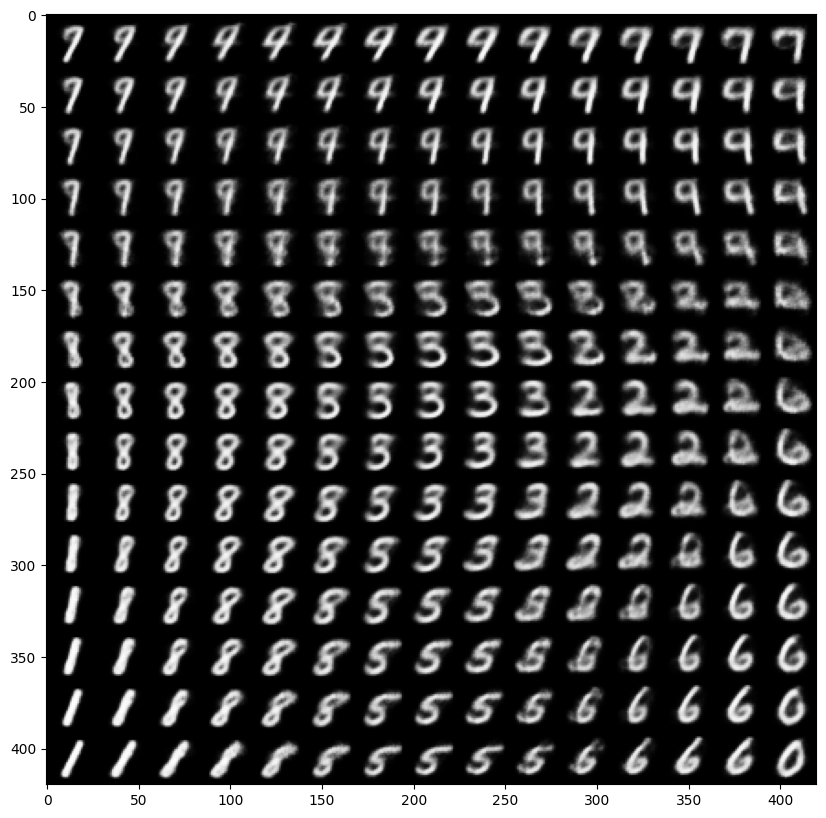

In [11]:
'''
Once such a model is trained -- e.g. on MNIST, in our case --
we can use the decoder network to turn arbitrary latent space vectors into images:
'''
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
digit_image = results_dir.joinpath('assignment12_MeyerJake_15x15_Digit_Grid.png')
plt.savefig(digit_image)
plt.show()